# Principal component analysis
Why is PCA important?
* Reduce computational time
* Reduce cost
* Preventing overfitting



## Create dataset
The purpose of this notebook is to look at PCA, so here we won't go into great detail about creating the dataset. But we'll leave it here, as opposed to just creating a CSV, as some of you maybe interested in the process. To create the dataset we used [make_classification()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html), which is a SKLearn funtion that allows us to create dummy data to test ML models, stating how many relevant features, irrelevant features, duplicate features, etc... we would like.

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

# NP equivilant of random state
np.random.seed(123)

# Return numbers spaced evenly on a log scale
# Gives the features different scales and makes a more interesting dataset
scale_values = np.logspace(1, 5, num=500)

# Create the X and y values for the DataFrame
X, y = make_classification(n_samples=5000,
                           n_features=500,
                           n_informative=280,
                           n_redundant=180,
                           n_repeated=3,
                           n_classes=6,
                           flip_y=0.1,
                           weights=[0.1, 0.2, 0.15, 0.25, 0.05],
                           n_clusters_per_class=1,
                           scale = scale_values,
                           random_state=42)

# Make the created values into DataFrames
X = pd.DataFrame(X)
y = pd.DataFrame(y)

# Rename the columns
X = X.add_prefix("feature_")
y.rename(columns={0:"label"}, inplace=True)

# Bring X and y together to view our DF as a whole
codealong_df = pd.concat([X, y], axis=1)

In [4]:
codealong_df.shape

(5000, 501)

## Train-test split

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(codealong_df,
                                       test_size=0.2,
                                       random_state=123)

X_train = train_set.drop(columns="label").copy()
y_train = train_set["label"].copy()

X_test = test_set.drop(columns="label").copy()
y_test = test_set["label"].copy()

### Iteration 1: No PCA

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

To help us see the effects of PCA we will time our models.

Here's a quick example of how we can time our cell and store that time as a variable.

In [7]:
import time

# At the start of cell define the start variable
start_time = time.time()

# Next comes our code
print("hello world")

# After the code define the end variable
end_time = time.time()

# Store the difference between the end and the start as a variable
time_taken = end_time - start_time

print("--- %s seconds ---" % (time_taken))

hello world
--- 0.0018777847290039062 seconds ---


Now, let's time our model.

In [8]:
# to change this into a regression pipeline, we need to
### 1) change the model into a Regressor i.e. DecisionTreeRegressor() in the pipeline and the paramters in paramgrid
### 2) change the scoring into a regression-metrics i.e. "neg_root_mean_squared_error"

start_time = time.time()

model_pipeline = make_pipeline(StandardScaler(),
                               # here we'd put the PCA (or the feature selection)
                               KNeighborsClassifier())   #DecisionTreeClassifier()

param_grid = {"kneighborsclassifier__n_neighbors": list(range(3, 30)),
              "kneighborsclassifier__weights":["uniform", "distance"],
              "kneighborsclassifier__p":[1,2]}

neigh1_search = RandomizedSearchCV(model_pipeline,
                                   param_grid,
                                   scoring="accuracy",
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=-2,
                                   random_state=123,
                                   verbose=1)

neigh1_search.fit(X_train, y_train)

end_time = time.time()

time_taken_no_pca = end_time - start_time
best_score_no_pca = neigh1_search.best_score_

print("--- %s seconds ---" % (time_taken_no_pca))
print(f"{round(best_score_no_pca * 100, 2)}% accuracy")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
--- 282.83670139312744 seconds ---
80.85% accuracy


## PCA

### Picking the number of components 1: a manual example

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10) # pick number of components
X_reduced = pca.fit_transform(X_train)

In [11]:
X_reduced.shape

(4000, 10)

In [12]:
pd.DataFrame(X_reduced)

,0,1,2,3,4,5,6,7,8,9
0,2.242329e+06,1.499770e+06,-3.552828e+06,3.404796e+06,4.758192e+06,3.260702e+06,-2.473214e+06,3.923069e+06,-2.681167e+06,1.440817e+06
1,8.138280e+05,1.777081e+06,-3.954372e+05,2.547296e+06,-7.020762e+06,4.811726e+06,-6.397595e+06,-4.308334e+06,-8.632591e+06,4.847201e+06
2,5.394411e+06,3.920421e+06,4.358932e+05,3.791027e+06,-7.748778e+06,4.181669e+06,1.307103e+06,-2.480762e+06,-2.005078e+06,1.607825e+06
3,-1.330090e+07,-1.482946e+06,-5.624582e+06,9.054270e+05,3.348938e+06,-1.360695e+06,6.520830e+06,1.202507e+06,1.843187e+06,-5.741201e+06
4,7.362607e+06,-4.354630e+06,-1.165859e+07,-4.664822e+05,4.891941e+06,2.844969e+06,7.466716e+06,-6.273848e+06,-8.602994e+06,-1.444685e+06
...,...,...,...,...,...,...,...,...,...,...
3995,-2.996059e+06,1.432155e+06,-9.025084e+05,-5.627994e+06,-5.300577e+06,-4.362612e+06,-3.574193e+06,7.780106e+05,-4.247038e+06,2.427715e+06
3996,6.884203e+06,3.115770e+06,3.033555e+06,7.209340e+05,-4.376324e+06,2.957824e+06,2.125534e+06,8.215452e+05,-2.306068e+06,-9.066719e+05
3997,5.175947e+06,-3.215260e+06,2.456789e+06,-5.247994e+06,-1.722428e+06,1.123004e+06,4.174641e+06,-8.808715e+05,-2.532054e+06,3.392128e+06
3998,-4.392218e+04,1.011949e+07,3.804045e+06,3.519990e+06,-1.702743e+06,-1.072220e+06,6.723666e+06,-3.685875e+06,1.747922e+06,-3.424222e+05


### Iteration 2: with PCA
Now that we've reduced the number of features to 10, from 500, let's see the effects that has.

In [13]:
start_time = time.time()

model_pipeline = make_pipeline(StandardScaler(),
                               PCA(n_components=10),
                               KNeighborsClassifier())

param_grid = {"kneighborsclassifier__n_neighbors": list(range(3, 30)),
              "kneighborsclassifier__weights":["uniform", "distance"],
              "kneighborsclassifier__p":[1,2]}

neigh2_search = RandomizedSearchCV(model_pipeline,
                                   param_grid,
                                   scoring="accuracy",
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=-1,
                                   random_state=123)

neigh2_search.fit(X_train, y_train)

end_time = time.time()

time_taken_10_pca = end_time - start_time
best_score_10_pca = neigh2_search.best_score_

print("--- %s seconds ---" % (time_taken_10_pca))
print(f"{round(best_score_10_pca * 100, 2)}% accuracy")

--- 70.98466944694519 seconds ---
29.9% accuracy


### Picking the number of components 2: by variance
As you saw above, if we are too heavy handed with PCA, and reduce the amount of columns too drastically, we have a massive effect on the accuracy. So, how do we know what the optimal amount of columns are?

We can explore the features using PCA's `explained_variance_ratio_` attribute. This highlights the amount of variance explained by each of the selected components. In other words, this will show us how much of the total variance, as a percentage, each of the columns accounts for.

We'll set `n_components` to `None` so we can explore the amount of variance of all components.

In [14]:
pca = PCA(n_components=None)
pca.fit(X_train)

np.round(pca.explained_variance_ratio_, 4)*100

array([5.54, 4.85, 4.19, 4.  , 3.75, 3.52, 3.28, 3.24, 3.03, 2.83, 2.79,
       2.5 , 2.38, 2.3 , 2.23, 2.08, 1.96, 1.88, 1.82, 1.78, 1.73, 1.66,
       1.54, 1.47, 1.42, 1.37, 1.31, 1.24, 1.19, 1.17, 1.12, 1.09, 1.01,
       0.96, 0.92, 0.89, 0.86, 0.81, 0.81, 0.78, 0.73, 0.69, 0.66, 0.63,
       0.6 , 0.57, 0.56, 0.55, 0.52, 0.49, 0.46, 0.43, 0.42, 0.4 , 0.38,
       0.37, 0.35, 0.34, 0.33, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.25, 0.24,
       0.23, 0.21, 0.21, 0.2 , 0.19, 0.19, 0.18, 0.17, 0.16, 0.15, 0.15,
       0.14, 0.14, 0.13, 0.12, 0.12, 0.12, 0.11, 0.1 , 0.1 , 0.1 , 0.09,
       0.08, 0.08, 0.08, 0.07, 0.07, 0.07, 0.07, 0.07, 0.06, 0.06, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.03,
       0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.

Look at all of the 0's at the end, looks like we have quite a few columns that are providing our model without a lot of information.

We can also visualise cumulative total of `pca.explained_variance_ratio_` to see how many of our columns are useful.

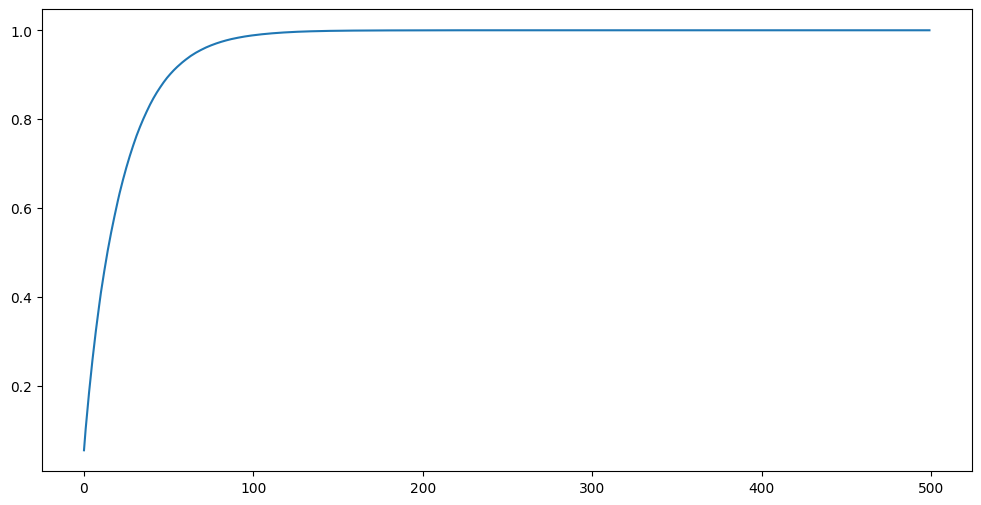

In [15]:
import matplotlib.pyplot as plt

cumsum = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumsum, label = "Explained variance");

It's common to choose the amount of features that make up 95% of the variance. This way we are feeding our model almost the same amount of data, but reducing the number of features. The cell below calculates the number of features that make up 95% of the variance.

In [ ]:
sum(cumsum < 0.95)

67

### Iteration 3: PCA and variance
In our pipeline we'll set the `n_components` of `PCA` to `0.95`. As the number is a float and not an integer, this tells SKLearn that we'd like PCA to reduce the number of column to those that contain 95% of the total variance.

In [16]:
start_time = time.time()

model_pipeline = make_pipeline(StandardScaler(),
                               PCA(n_components=0.95),
                               KNeighborsClassifier())

param_grid = {"kneighborsclassifier__n_neighbors": list(range(3, 30)),
              "kneighborsclassifier__weights":["uniform", "distance"],
              "kneighborsclassifier__p":[1,2]}

neigh3_search = RandomizedSearchCV(model_pipeline,
                                   param_grid,
                                   scoring="accuracy",
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=-1,
                                   random_state=123)

neigh3_search.fit(X_train, y_train)

end_time = time.time()

time_taken_95_pca = end_time - start_time
best_score_95_pca = neigh3_search.best_score_

print("--- %s seconds ---" % (time_taken_95_pca))
print(f"{round(best_score_95_pca * 100, 2)}% accuracy")

--- 245.9454848766327 seconds ---
81.27% accuracy


### Comparing the first 3 iterations
Let's have a look at the differences in time and accuracy across our 3 experiments.

In [17]:
variables_data = {'pca_version': ['None', '10', '0.95'],
                  'time': [time_taken_no_pca, time_taken_10_pca, time_taken_95_pca],
                  'accuracy': [best_score_no_pca, best_score_10_pca, best_score_95_pca]}

times_df = pd.DataFrame(variables_data)

times_df.set_index('pca_version', inplace=True)

times_df

,time,accuracy
pca_version,,
None,282.836701,0.80850
10,70.984669,0.29900
0.95,245.945485,0.81275


### Picking the number of components 3: cross validation

It is also possible to place different values for PCA in your parameter search to ensure you get the best fit for your data. This may seem counter productive at first, as we are training many pca models, and therefore losing our time gains. However, if you are retraining a model, as you've added some extra data to the dataset, you would just use the previous best value of `n_components` and retrain the model without full cross validation, and therefore benefit from the time gains.

First, let's look at how we would do the initial training with cross validation.

In [ ]:
start_time = time.time()

model_pipeline = make_pipeline(StandardScaler(),
                               PCA(),
                               KNeighborsClassifier())

param_grid = {"pca__n_components": list(range(10, 310, 20)),
              "kneighborsclassifier__n_neighbors": list(range(3, 30)),
              "kneighborsclassifier__weights":["uniform", "distance"],
              "kneighborsclassifier__p":[1,2]}

neigh4_search = RandomizedSearchCV(model_pipeline,
                                   param_grid,
                                   scoring="accuracy",
                                   n_iter=50,
                                   cv=5,
                                   n_jobs=-1,
                                   random_state=123)

neigh4_search.fit(X_train, y_train)

end_time = time.time()

time_taken_search_pca = end_time - start_time
best_score_search_pca = neigh4_search.best_score_

print("--- %s seconds ---" % (time_taken_search_pca))
print(f"{round(best_score_search_pca * 100, 2)}% accuracy")

--- 114.5195164680481 seconds ---
81.18% accuracy


Next, let's look at how quick it would be to retrain our model using the same parameters.

In [ ]:
neigh4_search.best_params_

{'pca__n_components': 250,
 'kneighborsclassifier__weights': 'uniform',
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__n_neighbors': 27}

In [ ]:
start_time = time.time()

model_pipeline = make_pipeline(StandardScaler(),
                               PCA(n_components=250),
                               KNeighborsClassifier(weights='uniform',
                                                    p=2,
                                                    n_neighbors=27))

model_pipeline.fit(X_train, y_train)

end_time = time.time()

time_taken_retrain_pca = end_time - start_time
best_score_retrain_pca = model_pipeline.score(X_train, y_train)

print("--- %s seconds ---" % (time_taken_retrain_pca))
print(f"{round(best_score_retrain_pca * 100, 2)}% accuracy")

--- 0.7278356552124023 seconds ---
85.72% accuracy




> **Note:** the uptick in accuracy for the retrained model is likely due to the fact that this is the only model not using cross validation. Remember, cross validation breaks the training data down into smaller chunks and uses each as a test set, then gives us the average accuracy of all tests. Here we just have the a non-averaged accuracy of a larger training set.



### Comparing all 5 models

In [ ]:
variables_data = {'pca_version': ['None', '10', '0.95', 'Cross validation', 'Retrain only'],
                  'time': [time_taken_no_pca, time_taken_10_pca, time_taken_95_pca, time_taken_search_pca, time_taken_retrain_pca],
                  'accuracy': [best_score_no_pca, best_score_10_pca, best_score_95_pca, best_score_search_pca, best_score_retrain_pca]}

times_df = pd.DataFrame(variables_data)

times_df.set_index('pca_version', inplace=True)

times_df

,time,accuracy
pca_version,,
None,499.795150,0.80850
10,43.906825,0.29825
0.95,303.465890,0.81275
Cross validation,114.519516,0.81175
Retrain only,0.727836,0.85725


## Practice:

- Apply PCA to the Diamonds dataset.
- Apply PCA to the Housing case study Pipeline.

In both cases, tune the number of components and analyse whether the performance improves, stays stable or decreases.